#### EDA-two very quickly became statistical soup. So we're starting fresh here

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# import simpreglib as srl
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

Define functions 

In [2]:
# creates dictionary of variance inflation factors. 
def create_vif_dictionary(X):
    vif_dct = {}
    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dct[v] = vif
    return vif_dct

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):
    adj_R_squares = {}
    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# ValueError: list.remove(x): x not in list

Define baseline data

In [3]:
# creating a target 'y' and predictors 'X'
df = pd.read_csv('data/cleaned_kc.csv')
# df = pd.read_csv('data/kc_house_data.csv')
y = df.price
X = df.iloc[:,1:]

In [4]:
# converting age from a datetime object into a number
ages = []
for age in X.age:
    age = age.split()[0]
    ages.append(float(age))
X.age = ages

In [5]:
# standardization of data
Xs = pd.DataFrame([])
for feature in X.columns:
    x_comp = (X[feature] - np.mean(X[feature])/np.std(X[feature]))
    Xs[feature] = x_comp 

investigate multi-colinearity

In [6]:
# Xs.corr()

In [7]:
# abs(Xs.corr()) > 0.75

In [8]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
cor_df=Xs.corr().abs().stack().reset_index().sort_values(0, ascending=False)
# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
# set index to pairs
cor_df.set_index(['pairs'], inplace = True)
#drop level columns
cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
# rename correlation column as cc rather than 0
cor_df.columns = ['cc']
# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
cor_df.drop_duplicates(inplace=True)

In [9]:
cor_df[(cor_df.cc>.75) & (cor_df.cc <1)]

,cc
pairs,
"(yr_built, age)",1.000000
"(level_difference, sqft_above)",0.887606
"(sqft_above, sqft_living)",0.876678
"(sqft_living15, sqft_living)",0.756389
"(sqft_living, bathrooms)",0.755278
"(sqft_lot, relative_lot_size)",0.754121


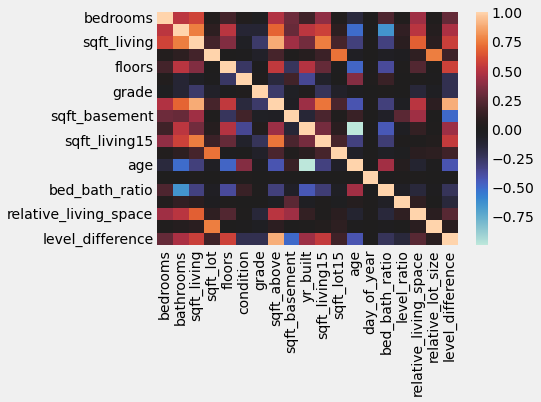

In [10]:
sns.heatmap(Xs.corr(), center=0);

In [11]:
r_squares = create_R2_dictionary(Xs,y)

In [12]:
# r_squares

In [13]:
vifs = create_vif_dictionary(Xs)
good_vifs = []
bad_vifs = [] 
for k,v in vifs.items():
    if v < 10 :
        good_vifs.append(k)
    else:
        bad_vifs.append(k)

In [14]:
for feature in good_vifs:
    print(feature, r_squares[feature])   

bedrooms 0.096
grade 0.116
day_of_year 0.0
level_ratio 0.016


#### ranking features using stepwise method
doc string for stepwise function:
Perform a forward-backward feature selection based on p-value from statsmodels.api.OLS Arguments:
- X - pandas.DataFrame with candidate features
- y - list-like with the target
- initial_list - list of features to start with (column names of X)
- threshold_in - include a feature if its p-value < threshold_in
- threshold_out - exclude a feature if its p-value > threshold_out
- verbose - whether to print the sequence of inclusions and exclusions
- Returns: list of selected features 

- default params : threshold_in=0.01, threshold_out = 0.05, verbose=True

Always set threshold_in < threshold_out to avoid infinite looping.
See https://en.wikipedia.org/wiki/Stepwise_regression for the details

In [15]:
type(list(y))

list

In [16]:
result = stepwise_selection(Xs, y, Xs.columns,threshold_in=0.01, threshold_out = 0.05, verbose=True)

Drop sqft_living15                  with p-value 0.72863
Drop level_difference               with p-value 0.759798
Drop sqft_lot15                     with p-value 0.763658
Drop sqft_living                    with p-value 0.447286
Drop yr_built                       with p-value 0.447269
Add  sqft_living                    with p-value 1.88341e-16
Add  level_difference               with p-value 3.53546e-16
Add  sqft_lot15                     with p-value 3.81501e-16
Add  sqft_living15                  with p-value 5.25541e-16


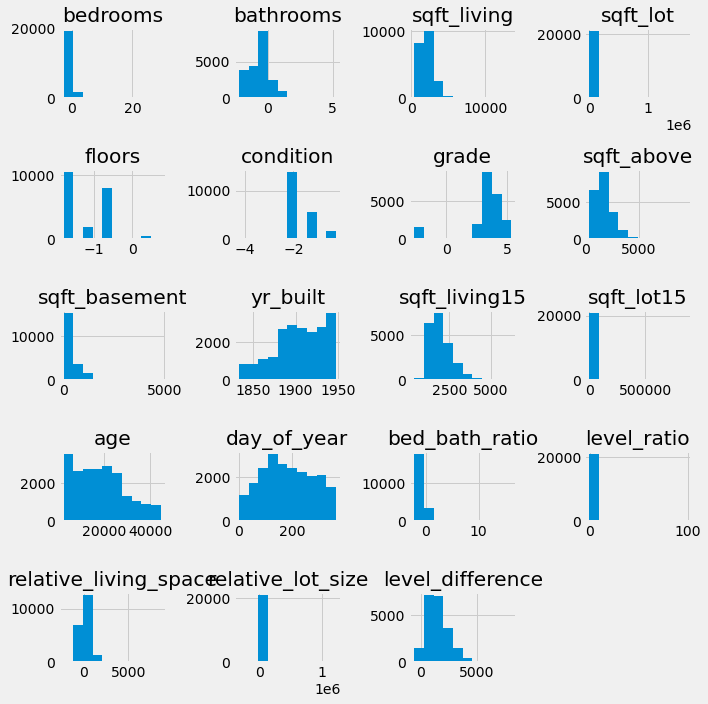

In [17]:
Xs.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

#### ranking feautre using recursive elimination

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [19]:
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=6)
selector = selector.fit(Xs, y)

In [20]:
selected = selector.support_ # list of bools representing if feature is selected or not
selections = [] # list of column names that are selected
labels = list(Xs.columns) # list of all column names 

for idx,feature in enumerate(selected): # append labels of selected features to selections list
    if feature == True:
        selections.append(labels[idx])
    else:
        pass
print(selections) 

['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'bed_bath_ratio']


In [21]:
# same as above but using ranking_ instead of support_

ranked = selector.ranking_ # list of bools representing if feature is selected or not
rankers = [] # list of column names that are selected
labels = list(Xs.columns) # list of all column names 

for idx,feature in enumerate(ranked): # append labels of selected features to selections list
    if feature == 1:
        rankers.append(labels[idx])
    else:
        pass
print(rankers) 

['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'bed_bath_ratio']
